# Goal-Based Investment Planner

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import gradio as gr
from tqdm import tqdm

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

In [5]:
# Load the datasets
print("Loading datasets...")

# Load Gold data
gold_df = pd.read_csv('data/GoldPrice.csv')

# Load Nifty50 data
nifty_df = pd.read_csv('data/NIFTY50_all.csv')

# Load Bitcoin data in INR
bitcoin_inr_df = pd.read_csv('data/btc_inr_final.csv')

# Display basic information about the datasets
print("\nGold data shape:", gold_df.shape)
print("Bitcoin INR data shape:", bitcoin_inr_df.shape)
print("Nifty data shape:", nifty_df.shape)

# Display the first few rows of each dataset
print("\nGold Data Preview:")
print(gold_df.head())
print("\nBitcoin INR Data Preview:")
print(bitcoin_inr_df.head())
print("\nNifty Data Preview:")
print(nifty_df.head())

Loading datasets...

Gold data shape: (2848, 7)
Bitcoin INR data shape: (2107, 7)
Nifty data shape: (235192, 15)

Gold Data Preview:
         Date  Price   Open   High    Low  Volume  Chg%
0  2025-01-06  77149  77309  77542  76545   27160  0.44
1  2025-01-03  76813  77246  78600  76613      60 -0.05
2  2025-01-02  76849  76849  76849  76849       0  0.83
3  2025-01-01  76214  76232  76302  76053      60 -0.02
4  2024-12-31  76232  75680  76970  75572    1920  0.95

Bitcoin INR Data Preview:
         Date          Open          High           Low         Close  \
0  2015-08-22  15361.229492  15512.753906  14703.763672  15211.223633   
1  2015-08-23  15210.299805  15364.068359  14893.648438  15064.584961   
2  2015-08-24  15060.821289  15062.604492  14058.517578  14061.992188   
3  2015-08-25  14033.465820  14989.896484  13331.954102  14688.354492   
4  2015-08-26  14719.308594  15291.668945  14610.535156  14917.085938   

      Adj Close        Volume  
0  15211.223633  1.532142e+09  
1


Cleaned Gold Data:
             Gold
Date             
2014-01-01  29542
2014-01-02  29975
2014-01-03  29727
2014-01-04  29279
2014-01-06  29119

Cleaned Bitcoin INR Data:
                 Bitcoin
Date                    
2015-08-22  15211.223633
2015-08-23  15064.584961
2015-08-24  14061.992188
2015-08-25  14688.354492
2015-08-26  14917.085938

Cleaned Nifty50 Data:
                Nifty50
Date                   
2000-01-03  1046.295455
2000-01-04  1096.909091
2000-01-05  1047.637879
2000-01-06  1019.443939
2000-01-07   971.904545

Missing values in Gold data: Gold    0
dtype: int64
Missing values in Bitcoin INR data: Bitcoin    3
dtype: int64
Missing values in Nifty50 data: Nifty50    0
dtype: int64

Aligning data from 2015-08-22 00:00:00 to 2021-04-30 00:00:00

Monthly Gold Data:
             Gold
Date             
2015-08-31  26540
2015-09-30  25803
2015-10-31  26355
2015-11-30  25114
2015-12-31  24952

Monthly Bitcoin INR Data:
                 Bitcoin
Date                    
20

C:\Users\Shrey\AppData\Local\Temp\ipykernel_16616\1108894555.py:90: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gold_monthly = gold_clean.resample('M').last()
C:\Users\Shrey\AppData\Local\Temp\ipykernel_16616\1108894555.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  bitcoin_monthly = bitcoin_clean.resample('M').last()
C:\Users\Shrey\AppData\Local\Temp\ipykernel_16616\1108894555.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  nifty_monthly = nifty_clean.resample('M').last()


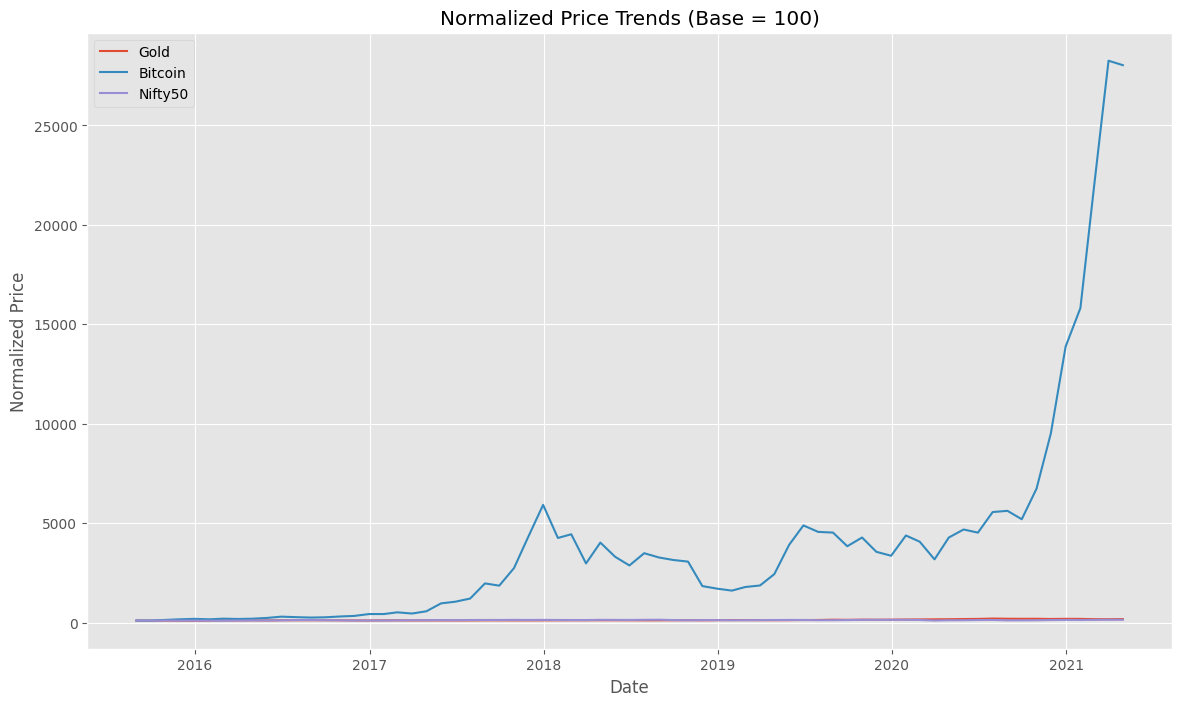

In [6]:
# Function to clean and process data
def clean_data(df, date_col='Date', price_col='Close', name=None):
    """
    Clean and process financial data
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe to clean
    date_col : str
        Name of the date column
    price_col : str
        Name of the closing price column
    name : str
        Name to assign to the asset
        
    Returns:
    --------
    pandas DataFrame
        Cleaned dataframe with date as index and closing price
    """
    # Create a copy to avoid modifying the original
    df_clean = df.copy()
    
    # Convert date to datetime
    df_clean[date_col] = pd.to_datetime(df_clean[date_col])
    
    # Set date as index
    df_clean.set_index(date_col, inplace=True)
    
    # Sort by date
    df_clean.sort_index(inplace=True)
    
    # Select only the closing price
    df_clean = df_clean[[price_col]]
    
    # Rename the column to the asset name
    if name:
        df_clean.rename(columns={price_col: name}, inplace=True)
    
    return df_clean

# Clean Gold data
gold_clean = clean_data(gold_df, date_col='Date', price_col='Price', name='Gold')

# Clean Bitcoin INR data
bitcoin_clean = clean_data(bitcoin_inr_df, date_col='Date', price_col='Close', name='Bitcoin')

# For Nifty50, we need to filter to get only the index data
# First check if 'NIFTY 50' exists in the Symbol column
if 'NIFTY 50' in nifty_df['Symbol'].unique():
    # Filter for NIFTY 50 index data
    nifty_index_df = nifty_df[nifty_df['Symbol'] == 'NIFTY 50']
    nifty_clean = clean_data(nifty_index_df, date_col='Date', price_col='Close', name='Nifty50')
else:
    # If NIFTY 50 is not found, use all data but aggregate by date
    # This is a simplification - in reality we'd need to create a proper index
    nifty_df_grouped = nifty_df.groupby('Date')['Close'].mean().reset_index()
    nifty_clean = clean_data(nifty_df_grouped, date_col='Date', price_col='Close', name='Nifty50')

# Display the cleaned dataframes
print("\nCleaned Gold Data:")
print(gold_clean.head())
print("\nCleaned Bitcoin INR Data:")
print(bitcoin_clean.head())
print("\nCleaned Nifty50 Data:")
print(nifty_clean.head())

# Check for missing values
print("\nMissing values in Gold data:", gold_clean.isnull().sum())
print("Missing values in Bitcoin INR data:", bitcoin_clean.isnull().sum())
print("Missing values in Nifty50 data:", nifty_clean.isnull().sum())

# Handle missing values if any
gold_clean = gold_clean.dropna()
bitcoin_clean = bitcoin_clean.dropna()
nifty_clean = nifty_clean.dropna()

# Align the date ranges for all assets
start_date = max(gold_clean.index.min(), bitcoin_clean.index.min(), nifty_clean.index.min())
end_date = min(gold_clean.index.max(), bitcoin_clean.index.max(), nifty_clean.index.max())

print(f"\nAligning data from {start_date} to {end_date}")

gold_clean = gold_clean.loc[start_date:end_date]
bitcoin_clean = bitcoin_clean.loc[start_date:end_date]
nifty_clean = nifty_clean.loc[start_date:end_date]

# Resample to monthly data to smooth out daily fluctuations
gold_monthly = gold_clean.resample('M').last()
bitcoin_monthly = bitcoin_clean.resample('M').last()
nifty_monthly = nifty_clean.resample('M').last()

# Display monthly data
print("\nMonthly Gold Data:")
print(gold_monthly.head())
print("\nMonthly Bitcoin INR Data:")
print(bitcoin_monthly.head())
print("\nMonthly Nifty50 Data:")
print(nifty_monthly.head())

# Combine all assets into a single dataframe
combined_df = pd.concat([gold_monthly, bitcoin_monthly, nifty_monthly], axis=1)
print("\nCombined Monthly Data:")
print(combined_df.head())

# Plot the price trends
plt.figure(figsize=(14, 8))

# Normalize the data to start at 100 for comparison
gold_normalized = gold_monthly / gold_monthly.iloc[0] * 100
bitcoin_normalized = bitcoin_monthly / bitcoin_monthly.iloc[0] * 100
nifty_normalized = nifty_monthly / nifty_monthly.iloc[0] * 100

# Plot normalized data
plt.plot(gold_normalized.index, gold_normalized['Gold'], label='Gold')
plt.plot(bitcoin_normalized.index, bitcoin_normalized['Bitcoin'], label='Bitcoin')
plt.plot(nifty_normalized.index, nifty_normalized['Nifty50'], label='Nifty50')

plt.title('Normalized Price Trends (Base = 100)')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Shrey\AppData\Local\Temp\ipykernel_16616\3190239374.py:17: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = df.resample('Y').last()


Yearly Returns:
                Gold    Bitcoin   Nifty50
Date                                     
2016-12-31  0.110131   1.297320  0.036427
2017-12-31  0.060361  12.799462  0.308527
2018-12-31  0.072075  -0.711847 -0.075191
2019-12-31  0.238496   0.969886  0.097501
2020-12-31  0.284161   3.130914 -0.015562
2021-12-31 -0.072882   1.019562  0.048472

Average Annual Returns:
Gold: 11.54%
Bitcoin: 308.42%
Nifty50: 6.67%

Annual Volatility:
Gold: 12.96%
Bitcoin: 491.37%
Nifty50: 13.23%

Sharpe Ratios:
Gold: 0.58
Bitcoin: 0.62
Nifty50: 0.20


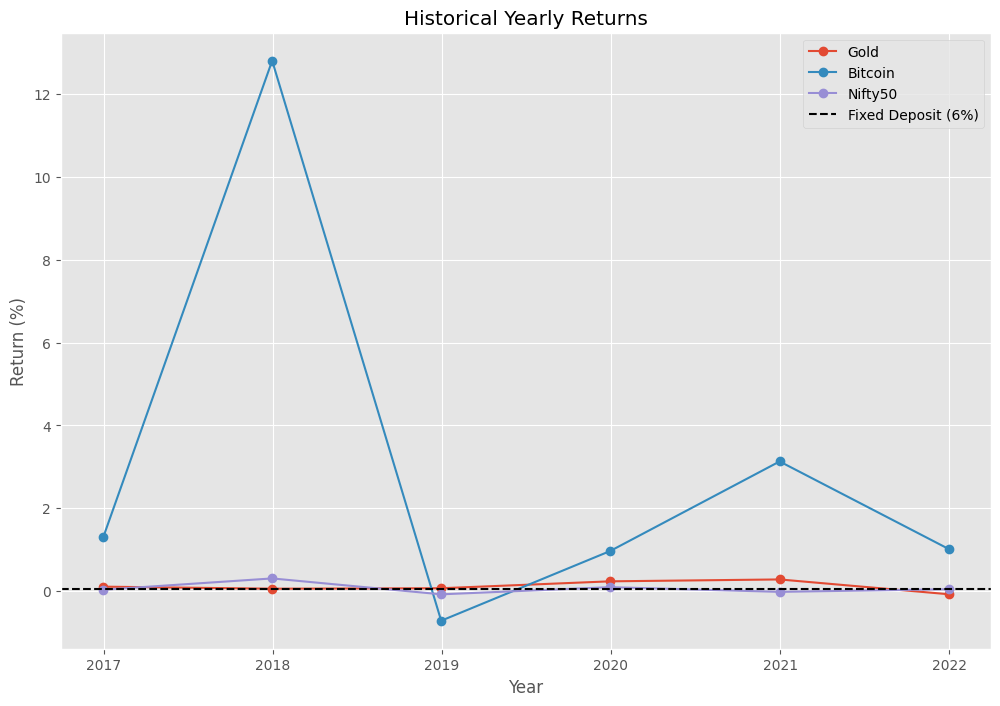

C:\Users\Shrey\AppData\Local\Temp\ipykernel_16616\3190239374.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(asset, (volatility[i], avg_returns[i]),


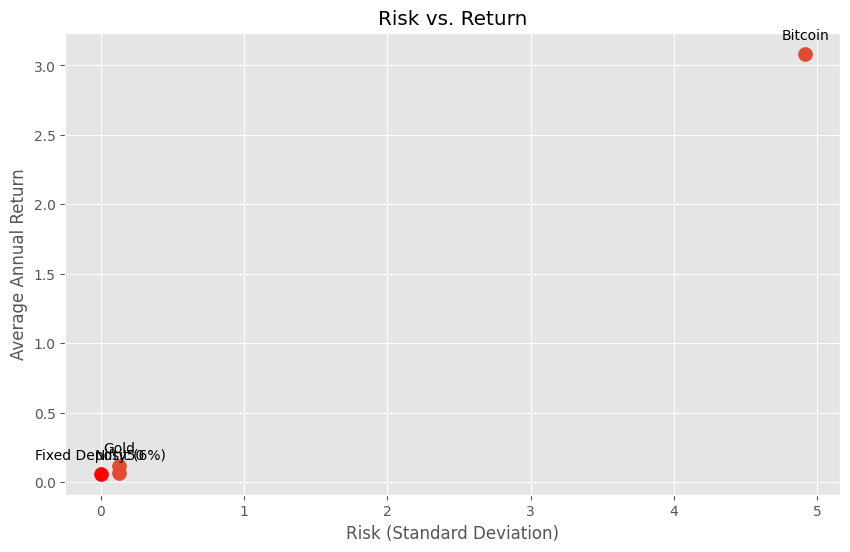

In [7]:
# Function to calculate yearly returns
def calculate_yearly_returns(df):
    """
    Calculate yearly returns from a dataframe with monthly closing prices
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with date as index and closing price as columns
        
    Returns:
    --------
    pandas DataFrame
        DataFrame with yearly returns
    """
    # Resample to yearly data (end of year)
    yearly_data = df.resample('Y').last()
    
    # Calculate yearly returns
    yearly_returns = yearly_data.pct_change().dropna()
    
    return yearly_returns

# Calculate yearly returns for each asset
yearly_returns = calculate_yearly_returns(combined_df)
print("Yearly Returns:")
print(yearly_returns)

# Calculate average annual returns and volatility (standard deviation)
avg_returns = yearly_returns.mean()
volatility = yearly_returns.std()

print("\nAverage Annual Returns:")
for asset in avg_returns.index:
    print(f"{asset}: {avg_returns[asset]:.2%}")

print("\nAnnual Volatility:")
for asset in volatility.index:
    print(f"{asset}: {volatility[asset]:.2%}")

# Calculate risk-adjusted returns (Sharpe ratio assuming risk-free rate of 4%)
risk_free_rate = 0.04
sharpe_ratios = (avg_returns - risk_free_rate) / volatility

print("\nSharpe Ratios:")
for asset in sharpe_ratios.index:
    print(f"{asset}: {sharpe_ratios[asset]:.2f}")

# Visualize historical returns
plt.figure(figsize=(12, 8))
for column in yearly_returns.columns:
    plt.plot(yearly_returns.index, yearly_returns[column], marker='o', label=column)

plt.axhline(y=0.06, color='black', linestyle='--', label='Fixed Deposit (6%)')
plt.title('Historical Yearly Returns')
plt.xlabel('Year')
plt.ylabel('Return (%)')
plt.legend()
plt.grid(True)
plt.show()

# Visualize risk vs. return
plt.figure(figsize=(10, 6))
plt.scatter(volatility, avg_returns, s=100)

# Add labels to each point
for i, asset in enumerate(avg_returns.index):
    plt.annotate(asset, (volatility[i], avg_returns[i]), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')

plt.scatter(0, 0.06, s=100, c='red')
plt.annotate('Fixed Deposit (6%)', (0, 0.06), 
             textcoords="offset points", 
             xytext=(0,10), 
             ha='center')

plt.title('Risk vs. Return')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Average Annual Return')
plt.grid(True)
plt.show()

CAGR (Compound Annual Growth Rate):
Gold: 10.38%
Bitcoin: 170.46%
Nifty50: 6.32%

Annual Volatility:
Gold: 12.96%
Bitcoin: 491.37%
Nifty50: 13.23%

Sharpe Ratios (based on CAGR):
Gold: 0.49
Bitcoin: 0.34
Nifty50: 0.18


C:\Users\Shrey\AppData\Local\Temp\ipykernel_16616\3190239374.py:17: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = df.resample('Y').last()
C:\Users\Shrey\AppData\Local\Temp\ipykernel_16616\2715467976.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(asset, (volatility[i], cagr_values[i]),


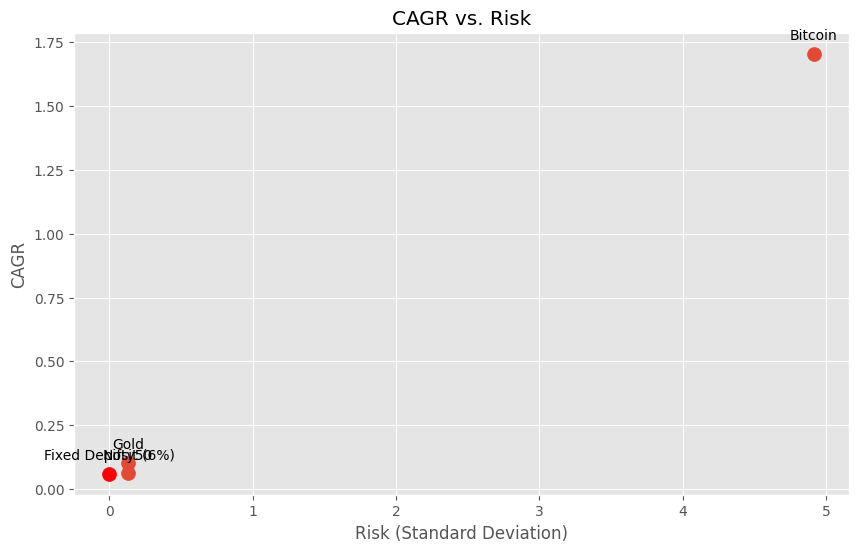

In [8]:
# Function to calculate CAGR (Compound Annual Growth Rate)
def calculate_cagr(df):
    """
    Calculate CAGR for each asset
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with date as index and closing price as columns
        
    Returns:
    --------
    pandas Series
        Series with CAGR for each asset
    """
    # Get first and last values
    first_values = df.iloc[0]
    last_values = df.iloc[-1]
    
    # Calculate number of years
    years = (df.index[-1] - df.index[0]).days / 365.25
    
    # Calculate CAGR
    cagr = (last_values / first_values) ** (1 / years) - 1
    
    return cagr

# Calculate CAGR for each asset
cagr_values = calculate_cagr(combined_df)
print("CAGR (Compound Annual Growth Rate):")
for asset in cagr_values.index:
    print(f"{asset}: {cagr_values[asset]:.2%}")

# Calculate yearly returns for volatility calculation
yearly_returns = calculate_yearly_returns(combined_df)
volatility = yearly_returns.std()

print("\nAnnual Volatility:")
for asset in volatility.index:
    print(f"{asset}: {volatility[asset]:.2%}")

# Calculate risk-adjusted returns (Sharpe ratio using CAGR and assuming risk-free rate of 4%)
risk_free_rate = 0.04
sharpe_ratios = (cagr_values - risk_free_rate) / volatility

print("\nSharpe Ratios (based on CAGR):")
for asset in sharpe_ratios.index:
    print(f"{asset}: {sharpe_ratios[asset]:.2f}")

# Visualize CAGR vs Volatility
plt.figure(figsize=(10, 6))
plt.scatter(volatility, cagr_values, s=100)

# Add labels to each point
for i, asset in enumerate(cagr_values.index):
    plt.annotate(asset, (volatility[i], cagr_values[i]), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')

plt.scatter(0, 0.06, s=100, c='red')
plt.annotate('Fixed Deposit (6%)', (0, 0.06), 
             textcoords="offset points", 
             xytext=(0,10), 
             ha='center')

plt.title('CAGR vs. Risk')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('CAGR')
plt.grid(True)
plt.show()

In [9]:
# Define risk profiles with asset allocations
risk_profiles = {
    'Conservative': {
        'FD': 0.60,
        'Gold': 0.30,
        'Nifty50': 0.10,
        'Bitcoin': 0.00
    },
    'Balanced': {
        'FD': 0.30,
        'Gold': 0.30,
        'Nifty50': 0.40,
        'Bitcoin': 0.00
    },
    'Aggressive': {
        'FD': 0.00,
        'Gold': 0.20,
        'Nifty50': 0.60,
        'Bitcoin': 0.20
    }
}

# Initialize dictionary to store profile volatilities
profile_volatility = {}

# Fixed deposit annual return
fd_return = 0.06  # Assuming 6% for Fixed Deposit

# Calculate covariance matrix of yearly returns for risky assets only (excluding FD)
risky_assets = ['Gold', 'Bitcoin', 'Nifty50']
risky_returns = yearly_returns[risky_assets]
cov_matrix_risky = risky_returns.cov()

print("Covariance Matrix (Risky Assets Only):")
print(cov_matrix_risky)

# Function to calculate portfolio volatility properly using covariance matrix
def calculate_portfolio_volatility(allocation, cov_matrix_risky):
    """
    Calculate portfolio volatility considering correlations between risky assets
    
    Parameters:
    -----------
    allocation : dict
        Asset allocation including FD
    cov_matrix_risky : pandas DataFrame
        Covariance matrix of risky asset returns
        
    Returns:
    --------
    float
        Portfolio volatility (standard deviation)
    """
    # Extract weights for risky assets
    risky_assets = cov_matrix_risky.columns
    
    # Calculate the sum of weights for risky assets
    risky_weight_sum = sum(allocation[asset] for asset in risky_assets)
    
    # If no risky assets, return 0 volatility
    if risky_weight_sum == 0:
        return 0
    
    # Normalize weights to sum to 1 for risky assets only
    normalized_weights = {asset: allocation[asset] / risky_weight_sum for asset in risky_assets}
    
    # Convert to array
    weight_array = np.array([normalized_weights[asset] for asset in risky_assets])
    
    # Calculate variance of risky portion
    risky_variance = weight_array.T @ cov_matrix_risky @ weight_array
    
    # Scale by the square of the total allocation to risky assets
    portfolio_variance = risky_variance * (risky_weight_sum ** 2)
    
    # Return portfolio volatility (standard deviation)
    return np.sqrt(portfolio_variance)

# Calculate expected volatility for each risk profile
for profile, allocation in risk_profiles.items():
    portfolio_vol = calculate_portfolio_volatility(allocation, cov_matrix_risky)
    profile_volatility[profile] = portfolio_vol

print("\nCorrected Expected Volatility by Risk Profile (excluding FD from covariance):")
for profile, vol in profile_volatility.items():
    print(f"{profile}: {vol:.2%}")

Covariance Matrix (Risky Assets Only):
             Gold    Bitcoin   Nifty50
Gold     0.016803  -0.044898 -0.002732
Bitcoin -0.044898  24.144894  0.582159
Nifty50 -0.002732   0.582159  0.017516

Corrected Expected Volatility by Risk Profile (excluding FD from covariance):
Conservative: 3.90%
Balanced: 6.05%
Aggressive: 105.27%


In [10]:
# Calculate expected returns (using CAGR) for each risk profile
profile_returns = {}

for profile, allocation in risk_profiles.items():
    # Expected return using CAGR
    expected_return = (
        allocation['FD'] * fd_return +
        allocation['Gold'] * cagr_values['Gold'] +
        allocation['Nifty50'] * cagr_values['Nifty50'] +
        allocation['Bitcoin'] * cagr_values['Bitcoin']
    )
    profile_returns[profile] = expected_return

print("Expected Annual Returns (CAGR) by Risk Profile:")
for profile, ret in profile_returns.items():
    print(f"{profile}: {ret:.2%}")

# Calculate risk-adjusted returns (Sharpe ratio using CAGR and corrected volatility)
risk_free_rate = 0.04  # Assuming 4% risk-free rate
sharpe_ratios = {}

for profile in risk_profiles.keys():
    # Avoid division by zero for Conservative profile (if it has 0 volatility)
    if profile_volatility[profile] > 0:
        sharpe_ratios[profile] = (profile_returns[profile] - risk_free_rate) / profile_volatility[profile]
    else:
        sharpe_ratios[profile] = float('inf')  # Infinite Sharpe ratio for zero volatility

print("\nSharpe Ratios (based on CAGR and corrected volatility):")
for profile, ratio in sharpe_ratios.items():
    if ratio == float('inf'):
        print(f"{profile}: Infinite (zero volatility)")
    else:
        print(f"{profile}: {ratio:.2f}")
        
print("\nSummary:")
print("{:<15} {:>20} {:>20} {:>20}".format("Profile", "Expected Return", "Volatility", "Sharpe Ratio"))
for profile in risk_profiles.keys():
    er = profile_returns[profile]
    vol = profile_volatility[profile]
    sr = sharpe_ratios[profile]
    sr_str = f"{sr:.2f}" if sr != float('inf') else "Infinite"
    print(f"{profile:<15} {er:>18.2%} {vol:>18.2%} {sr_str:>20}")

Expected Annual Returns (CAGR) by Risk Profile:
Conservative: 7.35%
Balanced: 7.44%
Aggressive: 39.96%

Sharpe Ratios (based on CAGR and corrected volatility):
Conservative: 0.86
Balanced: 0.57
Aggressive: 0.34

Summary:
Profile              Expected Return           Volatility         Sharpe Ratio
Conservative                 7.35%              3.90%                 0.86
Balanced                     7.44%              6.05%                 0.57
Aggressive                  39.96%            105.27%                 0.34


In [11]:
# Step 8: Generate synthetic data for ML model training

# Function to simulate investment growth with monthly SIP
def simulate_investment_growth(monthly_sip, duration_years, risk_profile, num_simulations=1000):
    """
    Simulate investment growth with monthly SIP for a given risk profile
    
    Parameters:
    -----------
    monthly_sip : float
        Monthly SIP amount
    duration_years : int
        Investment duration in years
    risk_profile : str
        Risk profile ('Conservative', 'Balanced', or 'Aggressive')
    num_simulations : int
        Number of Monte Carlo simulations to run
        
    Returns:
    --------
    float
        Expected final portfolio value
    """
    # Get allocation for the risk profile
    allocation = risk_profiles[risk_profile]
    
    # Get expected annual return and volatility for the risk profile
    expected_return = profile_returns[risk_profile]
    volatility = profile_volatility[risk_profile]
    
    # Number of months
    num_months = duration_years * 12
    
    # Initialize array to store final values from all simulations
    final_values = np.zeros(num_simulations)
    
    # Run simulations
    for sim in range(num_simulations):
        # Initialize portfolio value
        portfolio_value = 0
        
        # Simulate month-by-month
        for month in range(num_months):
            # Add monthly SIP
            portfolio_value += monthly_sip
            
            # Generate random monthly return (assuming normal distribution)
            monthly_return = np.random.normal(
                expected_return / 12,  # Monthly mean return
                volatility / np.sqrt(12),  # Monthly volatility
                1
            )[0]
            
            # Apply return to portfolio
            portfolio_value *= (1 + monthly_return)
        
        # Store final portfolio value
        final_values[sim] = portfolio_value
    
    # Return mean final value
    return np.mean(final_values)

# Generate synthetic data for training
print("Generating synthetic data for ML model training...")

# Define ranges for input parameters
monthly_sip_range = np.linspace(1000, 50000, 20)  # Monthly SIP from ₹1,000 to ₹50,000
duration_years_range = np.array([1, 2, 3, 5, 7, 10, 15, 20])  # Investment duration in years
risk_profiles_list = list(risk_profiles.keys())  # Risk profiles

# Create empty lists to store data
X_data = []  # Input features: [goal_amount, duration_years, risk_profile_encoded]
y_data = []  # Target: monthly_sip

# Generate data points
for monthly_sip in tqdm(monthly_sip_range):
    for duration_years in duration_years_range:
        for risk_profile in risk_profiles_list:
            # Simulate investment growth
            final_value = simulate_investment_growth(monthly_sip, duration_years, risk_profile)
            
            # Encode risk profile (0: Conservative, 1: Balanced, 2: Aggressive)
            risk_profile_encoded = risk_profiles_list.index(risk_profile)
            
            # Store data point (goal amount, duration, risk profile) -> monthly SIP
            X_data.append([final_value, duration_years, risk_profile_encoded])
            y_data.append(monthly_sip)

# Convert to numpy arrays
X_data = np.array(X_data)
y_data = np.array(y_data)

print(f"Generated {len(X_data)} synthetic data points")
print("X shape:", X_data.shape)
print("y shape:", y_data.shape)

# Display sample data points
print("\nSample data points (Goal Amount, Duration, Risk Profile -> Monthly SIP):")
for i in range(5):
    goal_amount = X_data[i][0]
    duration = X_data[i][1]
    risk_profile = risk_profiles_list[int(X_data[i][2])]
    monthly_sip = y_data[i]
    print(f"₹{goal_amount:.2f}, {duration} years, {risk_profile} -> ₹{monthly_sip:.2f} monthly SIP")

Generating synthetic data for ML model training...


100%|██████████| 20/20 [04:56<00:00, 14.81s/it]

Generated 480 synthetic data points
X shape: (480, 3)
y shape: (480,)

Sample data points (Goal Amount, Duration, Risk Profile -> Monthly SIP):
₹12484.97, 1.0 years, Conservative -> ₹1000.00 monthly SIP
₹12488.04, 1.0 years, Balanced -> ₹1000.00 monthly SIP
₹14688.22, 1.0 years, Aggressive -> ₹1000.00 monthly SIP
₹25922.37, 2.0 years, Conservative -> ₹1000.00 monthly SIP
₹25958.47, 2.0 years, Balanced -> ₹1000.00 monthly SIP


Training set shape: (384, 3)
Testing set shape: (96, 3)

Training RandomForestRegressor model...
Mean Squared Error: 12928819.67
R² Score: 0.9484

Feature Importance:
Goal Amount: 0.6404
Duration (years): 0.2957
Risk Profile: 0.0639


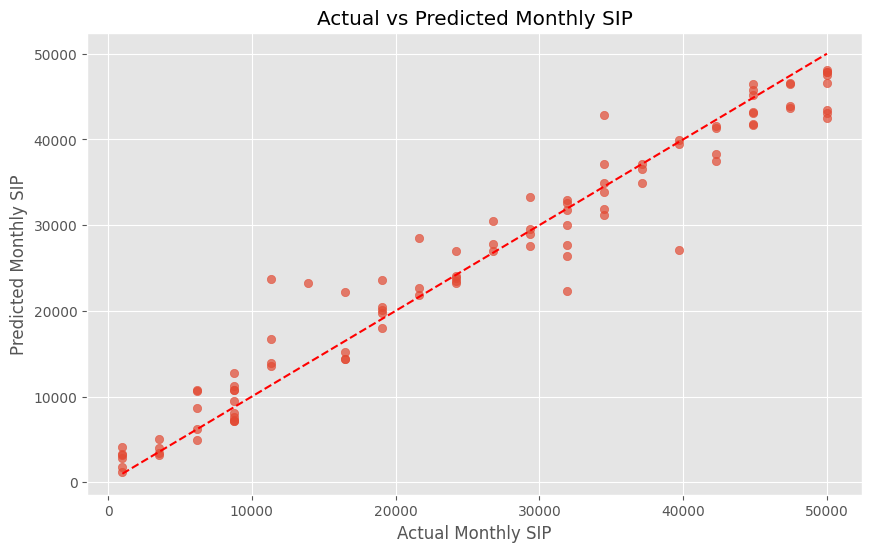


To reach ₹1,000,000 in 10 years with a Balanced risk profile:
Recommended monthly SIP: ₹6261.05


In [12]:
# Step 9: Train the ML model

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# Train a RandomForestRegressor model
print("\nTraining RandomForestRegressor model...")
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.4f}")

# Feature importance
feature_importance = model.feature_importances_
print("\nFeature Importance:")
features = ["Goal Amount", "Duration (years)", "Risk Profile"]
for i, importance in enumerate(feature_importance):
    print(f"{features[i]}: {importance:.4f}")

# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Monthly SIP')
plt.ylabel('Predicted Monthly SIP')
plt.title('Actual vs Predicted Monthly SIP')
plt.grid(True)
plt.show()

# Function to predict monthly SIP
def predict_monthly_sip(goal_amount, duration_years, risk_profile):
    """
    Predict monthly SIP required to reach a goal amount
    
    Parameters:
    -----------
    goal_amount : float
        Target amount to achieve
    duration_years : int
        Investment duration in years
    risk_profile : str
        Risk profile ('Conservative', 'Balanced', or 'Aggressive')
        
    Returns:
    --------
    float
        Recommended monthly SIP
    """
    # Encode risk profile
    risk_profile_encoded = risk_profiles_list.index(risk_profile)
    
    # Create input features
    X = np.array([[goal_amount, duration_years, risk_profile_encoded]])
    
    # Predict monthly SIP
    monthly_sip = model.predict(X)[0]
    
    return monthly_sip

# Test the prediction function
test_goal = 1000000  # ₹10 lakh
test_duration = 10  # 10 years
test_risk_profile = 'Balanced'

predicted_sip = predict_monthly_sip(test_goal, test_duration, test_risk_profile)
print(f"\nTo reach ₹{test_goal:,} in {test_duration} years with a {test_risk_profile} risk profile:")
print(f"Recommended monthly SIP: ₹{predicted_sip:.2f}")

In [13]:
# Step 10: Save the trained model
import joblib

# Save the model
model_filename = 'investment_predictor_model.joblib'
joblib.dump(model, model_filename)

# Save the risk profiles and other necessary data for the Gradio app
model_data = {
    'model': model,
    'risk_profiles': risk_profiles,
    'risk_profiles_list': risk_profiles_list,
    'profile_returns': profile_returns,
    'profile_volatility': profile_volatility
}

model_data_filename = 'investment_predictor_data.joblib'
joblib.dump(model_data, model_data_filename)

print(f"Model saved to {model_filename}")
print(f"Model data saved to {model_data_filename}")

Model saved to investment_predictor_model.joblib
Model data saved to investment_predictor_data.joblib


In [14]:
# Step 11: Build Gradio UI

def simulate_growth(monthly_sip, duration_years, risk_profile):
    """
    Simulate investment growth for visualization
    
    Parameters:
    -----------
    monthly_sip : float
        Monthly SIP amount
    duration_years : int
        Investment duration in years
    risk_profile : str
        Risk profile ('Conservative', 'Balanced', or 'Aggressive')
        
    Returns:
    --------
    tuple
        (months, portfolio_values)
    """
    # Get allocation for the risk profile
    allocation = risk_profiles[risk_profile]
    
    # Get expected annual return for the risk profile
    expected_return = profile_returns[risk_profile]
    
    # Number of months
    num_months = int(duration_years * 12)
    
    # Initialize arrays
    months = np.arange(num_months + 1)
    portfolio_values = np.zeros(num_months + 1)
    
    # Simulate month-by-month growth
    for month in range(1, num_months + 1):
        # Add monthly SIP
        portfolio_values[month] = portfolio_values[month - 1] + monthly_sip
        
        # Apply monthly return
        portfolio_values[month] *= (1 + expected_return / 12)
    
    return months, portfolio_values

def create_growth_chart(months, portfolio_values):
    """Create growth chart using Plotly"""
    fig = go.Figure()
    
    # Add investment amount line
    investment_amount = np.arange(len(months)) * portfolio_values[1]
    fig.add_trace(go.Scatter(
        x=months / 12,  # Convert to years
        y=investment_amount,
        mode='lines',
        name='Investment Amount',
        line=dict(color='blue', dash='dash')
    ))
    
    # Add portfolio value line
    fig.add_trace(go.Scatter(
        x=months / 12,  # Convert to years
        y=portfolio_values,
        mode='lines',
        name='Portfolio Value',
        line=dict(color='green')
    ))
    
    # Update layout
    fig.update_layout(
        title='Investment Growth Projection',
        xaxis_title='Years',
        yaxis_title='Amount (₹)',
        legend=dict(x=0.01, y=0.99),
        template='plotly_white'
    )
    
    return fig

def create_allocation_chart(risk_profile):
    """Create allocation pie chart using Plotly"""
    # Get allocation for the risk profile
    allocation = risk_profiles[risk_profile]
    
    # Create labels and values
    labels = list(allocation.keys())
    values = list(allocation.values())
    
    # Filter out zero allocations
    non_zero_indices = [i for i, v in enumerate(values) if v > 0]
    labels = [labels[i] for i in non_zero_indices]
    values = [values[i] for i in non_zero_indices]
    
    # Create colors
    colors = ['#FFA500', '#FFD700', '#4682B4', '#6495ED']
    
    # Create pie chart
    fig = go.Figure(data=[go.Pie(
        labels=labels,
        values=values,
        hole=.3,
        marker=dict(colors=colors)
    )])
    
    # Update layout
    fig.update_layout(
        title=f'Asset Allocation - {risk_profile} Profile',
        template='plotly_white'
    )
    
    return fig

def gradio_interface(goal_amount, duration_years, risk_profile):
    """
    Gradio interface function
    
    Parameters:
    -----------
    goal_amount : float
        Target amount to achieve
    duration_years : int
        Investment duration in years
    risk_profile : str
        Risk profile ('Conservative', 'Balanced', or 'Aggressive')
        
    Returns:
    --------
    tuple
        (monthly_sip, growth_chart, allocation_chart, summary)
    """
    # Predict monthly SIP
    monthly_sip = predict_monthly_sip(goal_amount, duration_years, risk_profile)
    
    # Round up to nearest 100
    monthly_sip = np.ceil(monthly_sip / 100) * 100
    
    # Simulate growth
    months, portfolio_values = simulate_growth(monthly_sip, duration_years, risk_profile)
    
    # Create growth chart
    growth_chart = create_growth_chart(months, portfolio_values)
    
    # Create allocation chart
    allocation_chart = create_allocation_chart(risk_profile)
    
    # Calculate total investment and expected returns
    total_investment = monthly_sip * duration_years * 12
    expected_final_value = portfolio_values[-1]
    expected_returns = expected_final_value - total_investment
    
    # Create summary
    summary = f"""
    ### Investment Summary
    
    **Monthly SIP:** ₹{monthly_sip:,.2f}
    
    **Total Investment:** ₹{total_investment:,.2f}
    
    **Expected Final Value:** ₹{expected_final_value:,.2f}
    
    **Expected Returns:** ₹{expected_returns:,.2f}
    
    **Expected CAGR:** {profile_returns[risk_profile]:.2%}
    
    **Expected Volatility:** {profile_volatility[risk_profile]:.2%}
    """
    
    return monthly_sip, growth_chart, allocation_chart, summary

# Create Gradio interface
demo = gr.Interface(
    fn=gradio_interface,
    inputs=[
        gr.Number(label="Goal Amount (₹)", value=1000000),
        gr.Slider(minimum=1, maximum=30, step=1, label="Duration (years)", value=10),
        gr.Radio(choices=risk_profiles_list, label="Risk Profile", value="Balanced")
    ],
    outputs=[
        gr.Number(label="Recommended Monthly SIP (₹)"),
        gr.Plot(label="Growth Projection"),
        gr.Plot(label="Asset Allocation"),
        gr.Markdown(label="Summary")
    ],
    title="Goal-Based Investment Predictor",
    description="Enter your financial goal, timeframe, and risk profile to get a recommended monthly SIP amount.",
    theme="default"
)

# Launch the app
demo.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
